In [1]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# 1. Data Preparation

In [4]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [5]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [6]:
def load_dataset(dataset_id, target):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id)

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index][target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    t_true = scaler.inverse_transform(np.transpose([y_true] * 5))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 5))[:, tidx]
    if tidx > 0:
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

In [8]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    Cs = np.logspace(-1.5, 1.5, 25)
    param_grid = [
    { 
        'scaler': [RobustScaler(),
                   PowerTransformer(),
                  ],
        'pca': [None, PCA(0.99)],
        'estimator__C': Cs,
        'estimator__gamma': ['scale', 'auto'],
        'estimator__kernel': ['rbf'],
        'estimator__cache_size': [2000],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [9]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    """
    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]
    """
    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [10]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [11]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__C'] = df_pred['param_estimator__C'].astype('float')
    df_pred['param_estimator__gamma'] = df_pred['param_estimator__gamma'].astype('str')
    
    return df_pred

In [12]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():
            for g in df_pred['param_estimator__gamma'].unique():

                df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                           df_pred['param_scaler']==s,
                                           df_pred['param_estimator__gamma']==g,
                                          ],
                                          axis=0).astype('bool')]
                df_plot = df_plot.sort_values('param_estimator__C')

                # Skip hyperparameter combination if not explored
                if df_plot.shape[0] == 0:
                    continue

                # Extract relevant modelling metrics
                train_scores = df_plot['mean_train_score']
                valid_scores = df_plot['mean_test_score']
                std_tr = df_plot['std_train_score']
                std_va = df_plot['std_test_score']

                plt.figure(figsize=(12, 4))
                alphas = df_plot['param_estimator__C']
                plt.semilogx(alphas, train_scores, label='Training Set')
                plt.semilogx(alphas, valid_scores, label='Validation Set')

                # Add marker and text for best score
                max_id = np.argmax(valid_scores)
                x_pos = alphas.iloc[max_id]
                y_pos = valid_scores.iloc[max_id]
                txt = '{:0.4f}'.format(y_pos)
                plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
                plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

                # Quantify variance with ±std curves
                plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
                plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
                plt.ylabel('Performance metric')
                plt.xlabel('Model parameter')

                # Adjust x-lim, y-lim, add legend and adjust layout
                plt.legend()
                plt.title('%s\n%s\n%s' % (str(s), str(p), str(g)))
                plt.show()

In [13]:
def run_prediction(model_metric, dataset_id='merge', target='age', estimator=None, scaler_targets=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset(dataset_id, target)
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [14]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:20])

In [15]:
def create_results_dataframe(predictions, scaler_targets, targets, test_id, feature_transform, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Reset scaling
    results = scaler_targets.inverse_transform(results)

    # Store results in Dataframe
    if res_type=='_te':
        df_results = pd.DataFrame(results, columns=targets.columns)

    elif res_type=='_tr':
        # Get location of missing values
        miss_columns = [k for k in predictions.keys() if 'miss' in k]
        entries = np.transpose([predictions[k] for k in miss_columns])

        # Create dataframe and fill up missing value places with NaN
        df_results = pd.concat(
            [pd.Series(dict(zip(train_id[entries[:, c]].astype('str'), results[c])))
             for c in range(len(miss_columns))], axis=1)
        df_results.columns = targets.columns

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    """
    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]
    """

    # Add ID back to test results
    if res_type=='_te':
        df_results.insert(0, 'Id', test_id)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [16]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [17]:
def save_results(predictions, scaler_targets, targets, test_id, feature_transform,
                 sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/submission_svr-rbf_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/results_tr_svr-rbf_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/results_te_svr-rbf_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [18]:
def plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(scaler_targets.inverse_transform(targets),
                              columns=targets.columns)

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

In [19]:
# Show list of available datasets
sorted(glob('datasets/*train.csv'))

['datasets/merge_train.csv', 'datasets/short_merge_train.csv']

Starting with dataset merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5865, 1405)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 101.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 131.1min finished


Best: -0.148237 using {'estimator__C': 1.7782794100389228, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


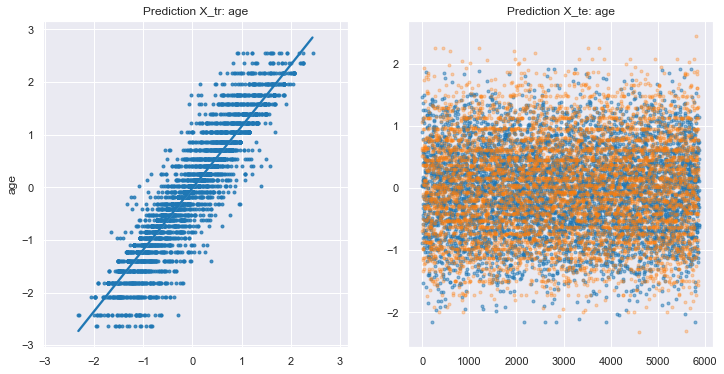

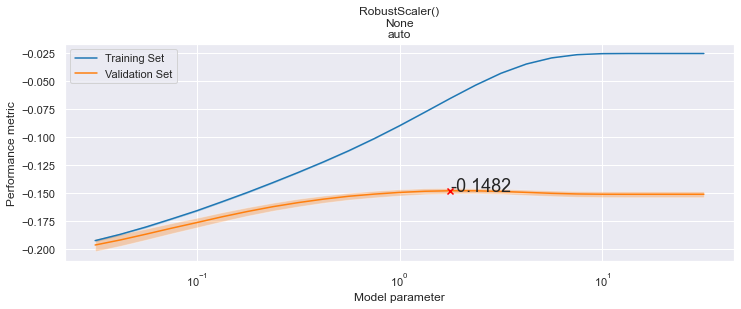

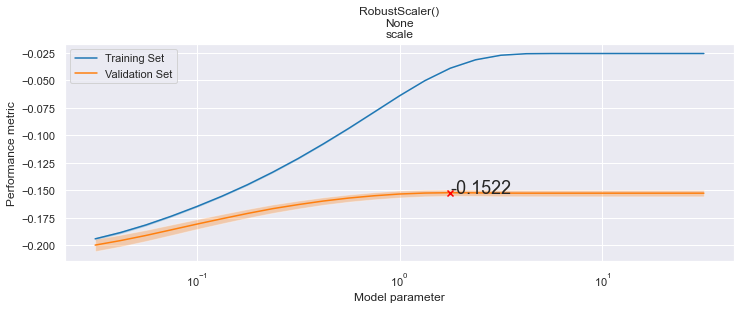

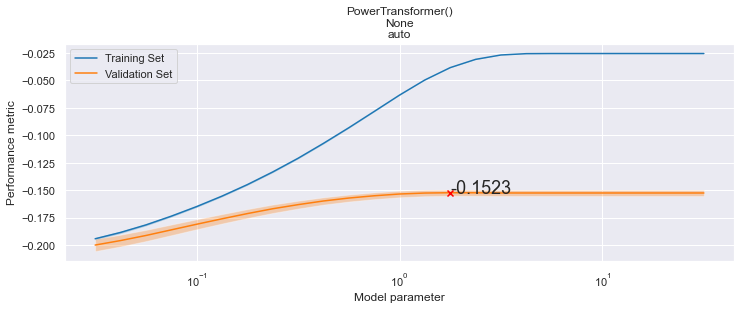

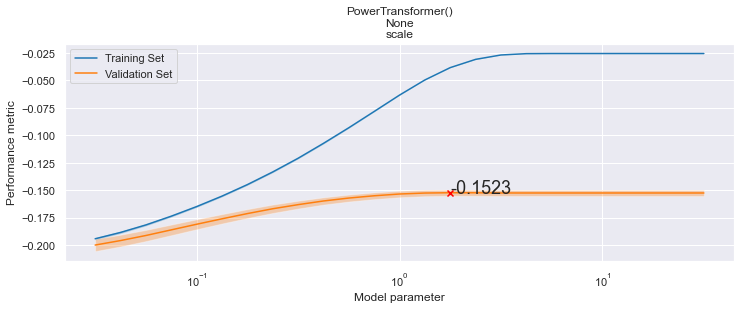

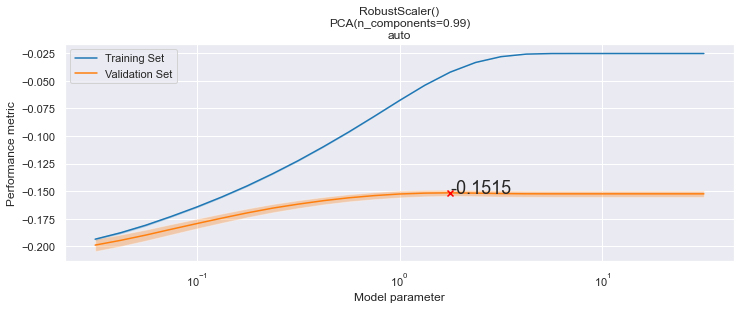

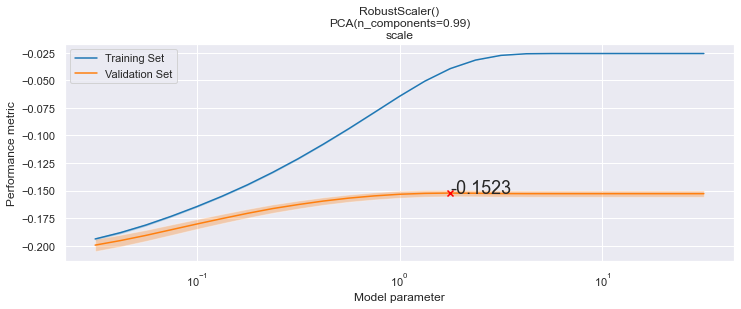

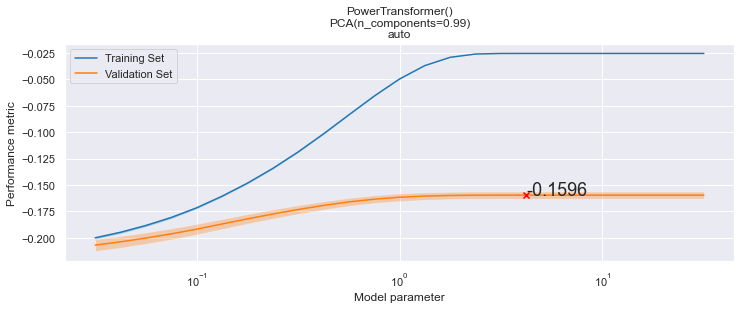

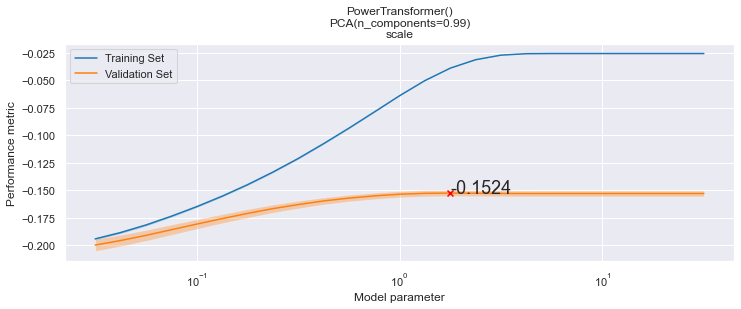

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
116            1.77828                        2000                   auto   
124            2.37137                        2000                   auto   
108            1.33352                        2000                   auto   
132            3.16228                        2000                   auto   
140            4.21697                        2000                   auto   
100                  1                        2000                   auto   
148            5.62341                        2000                   auto   
156            7.49894                        2000                   auto   
92            0.749894                        2000                   auto   
164                 10                        2000                   auto   
172            13.3352                        2000                   auto   
180            17.7828                        2000                   auto   
196            31.6228                        2000                   auto   
188            23.7137                        2000                   auto   
118            1.77828                        2000                   auto   
110            1.33352                        2000                   auto   
126            2.37137                        2000                   auto   
134            3.16228                        2000                   auto   
112            1.77828                        2000                  scale   
120            2.37137                        2000                  scale   

    param_estimator__kernel               param_pca    param_scaler  \
116                     rbf                    None  RobustScaler()   
124                     rbf                    None  RobustScaler()   
108                     rbf                    None  RobustScaler()   
132                     rbf                    None  RobustScaler()   
140                     rbf                    None  RobustScaler()   
100                     rbf                    None  RobustScaler()   
148                     rbf                    None  RobustScaler()   
156                     rbf                    None  RobustScaler()   
92                      rbf                    None  RobustScaler()   
164                     rbf                    None  RobustScaler()   
172                     rbf                    None  RobustScaler()   
180                     rbf                    None  RobustScaler()   
196                     rbf                    None  RobustScaler()   
188                     rbf                    None  RobustScaler()   
118                     rbf  PCA(n_components=0.99)  RobustScaler()   
110                     rbf  PCA(n_components=0.99)  RobustScaler()   
126                     rbf  PCA(n_components=0.99)  RobustScaler()   
134                     rbf  PCA(n_components=0.99)  RobustScaler()   
112                     rbf                    None  RobustScaler()   
120                     rbf                    None  RobustScaler()   

     mean_test_score  std_test_score  mean_train_score  std_train_score  
116        -0.148237        0.002442         -0.065698         0.000289  
124        -0.148269        0.002247         -0.053841         0.000341  
108        -0.148667        0.002609         -0.077998         0.000396  
132        -0.148842        0.002222         -0.043219         0.000402  
140        -0.149673        0.002408         -0.034950         0.000381  
100        -0.149723        0.002779         -0.090152         0.000500  
148        -0.150514        0.002451         -0.029472         0.000327  
156        -0.151083        0.002544         -0.026603         0.000177  
92         -0.151233        0.002917         -0.101664         0.000577  
164        -0.151320        0.002583         -0.025679         0.000103  
172        -0.151347        0.002608         -0.025560         0.000072  
180   

Starting with dataset merge - target: domain1_var1
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 89.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 115.9min finished


Best: -0.152407 using {'estimator__C': 0.5623413251903491, 'estimator__cache_size': 2000, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': PowerTransformer()}


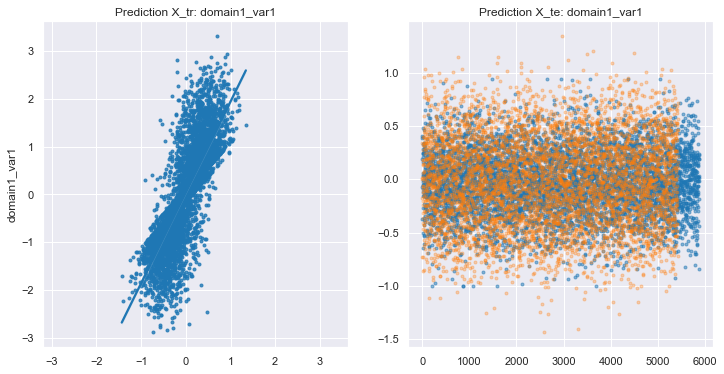

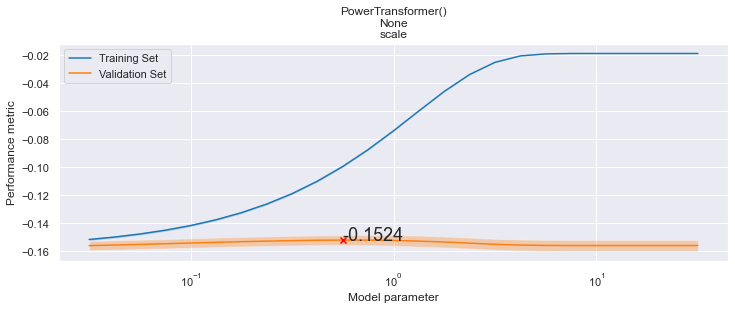

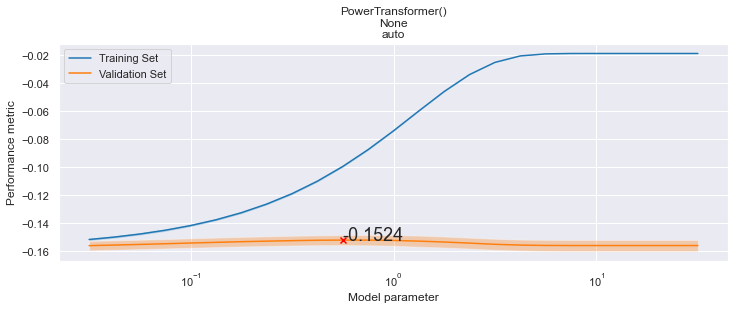

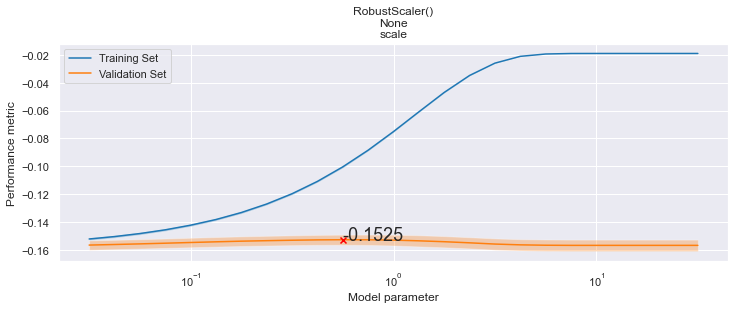

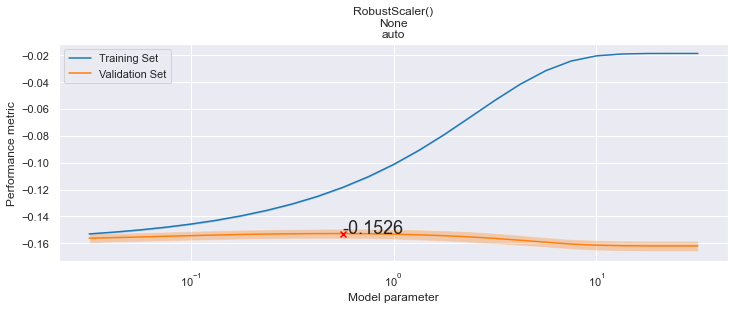

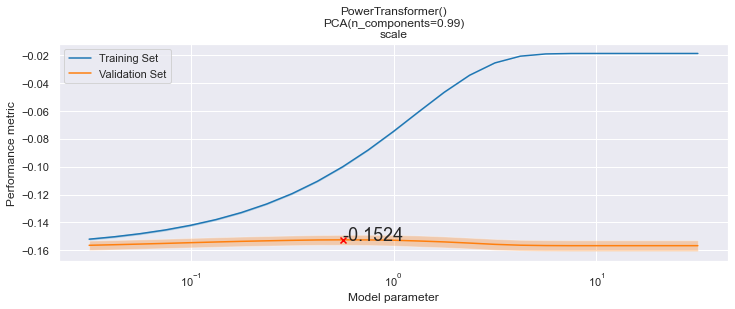

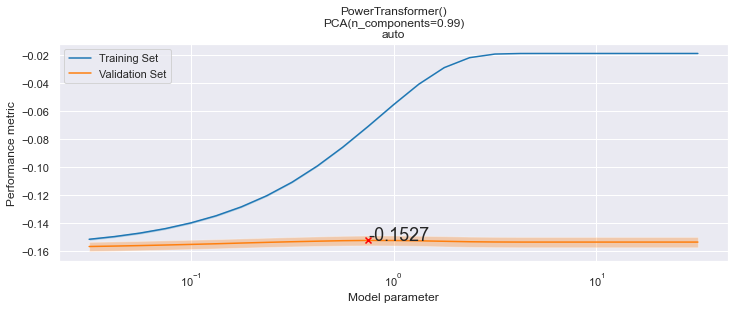

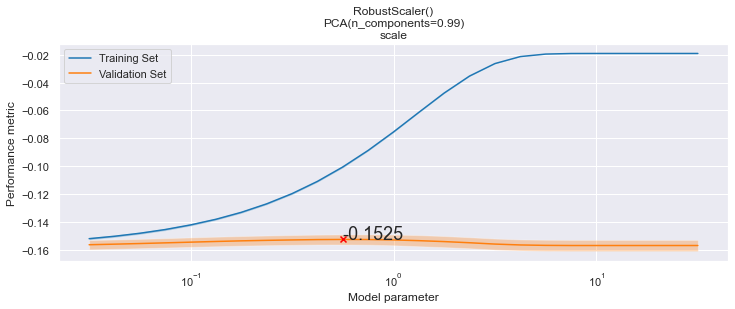

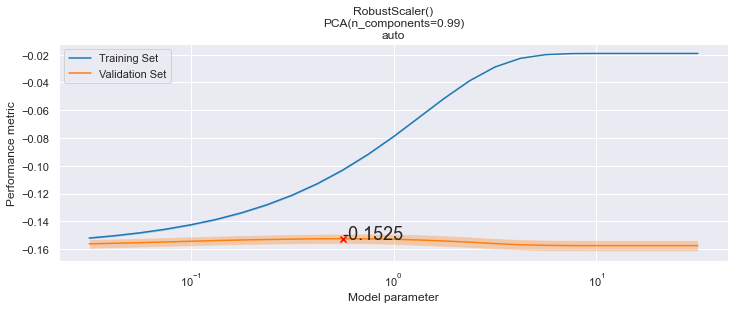

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
81            0.562341                        2000                  scale   
85            0.562341                        2000                   auto   
83            0.562341                        2000                  scale   
93            0.749894                        2000                   auto   
89            0.749894                        2000                  scale   
91            0.749894                        2000                  scale   
75            0.421697                        2000                  scale   
77            0.421697                        2000                   auto   
73            0.421697                        2000                  scale   
80            0.562341                        2000                  scale   
86            0.562341                        2000                   auto   
82            0.562341                        2000                  scale   
88            0.749894                        2000                  scale   
90            0.749894                        2000                  scale   
78            0.421697                        2000                   auto   
97                   1                        2000                  scale   
101                  1                        2000                   auto   
94            0.749894                        2000                   auto   
74            0.421697                        2000                  scale   
72            0.421697                        2000                  scale   

    param_estimator__kernel               param_pca        param_scaler  \
81                      rbf                    None  PowerTransformer()   
85                      rbf                    None  PowerTransformer()   
83                      rbf  PCA(n_components=0.99)  PowerTransformer()   
93                      rbf                    None  PowerTransformer()   
89                      rbf                    None  PowerTransformer()   
91                      rbf  PCA(n_components=0.99)  PowerTransformer()   
75                      rbf  PCA(n_components=0.99)  PowerTransformer()   
77                      rbf                    None  PowerTransformer()   
73                      rbf                    None  PowerTransformer()   
80                      rbf                    None      RobustScaler()   
86                      rbf  PCA(n_components=0.99)      RobustScaler()   
82                      rbf  PCA(n_components=0.99)      RobustScaler()   
88                      rbf                    None      RobustScaler()   
90                      rbf  PCA(n_components=0.99)      RobustScaler()   
78                      rbf  PCA(n_components=0.99)      RobustScaler()   
97                      rbf                    None  PowerTransformer()   
101                     rbf                    None  PowerTransformer()   
94                      rbf  PCA(n_components=0.99)      RobustScaler()   
74                      rbf  PCA(n_components=0.99)      RobustScaler()   
72                      rbf                    None      RobustScaler()   

     mean_test_score  std_test_score  mean_train_score  std_train_score  
81         -0.152407        0.003542         -0.099793         0.000704  
85         -0.152407        0.003542         -0.099798         0.000711  
83         -0.152424        0.003548         -0.100125         0.000706  
93         -0.152429        0.003655         -0.087760         0.000641  
89         -0.152429        0.003655         -0.087754         0.000632  
91         -0.152483        0.003647         -0.088190         0.000634  
75         -0.152517        0.003486         -0.110531         0.000715  
77         -0.152518        0.003483         -0.110295         0.000720  
73         -0.152518        0.003483         -0.110291         0.000713  
80         -0.152528        0.003604         -0.100341         0.00070

Starting with dataset merge - target: domain1_var2
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 89.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 116.1min finished


Best: -0.150715 using {'estimator__C': 0.05623413251903491, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


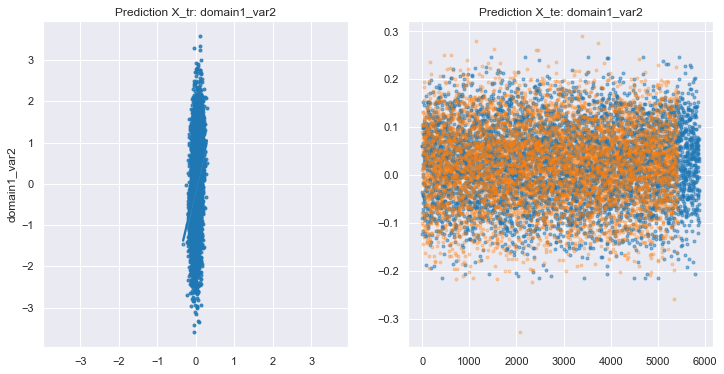

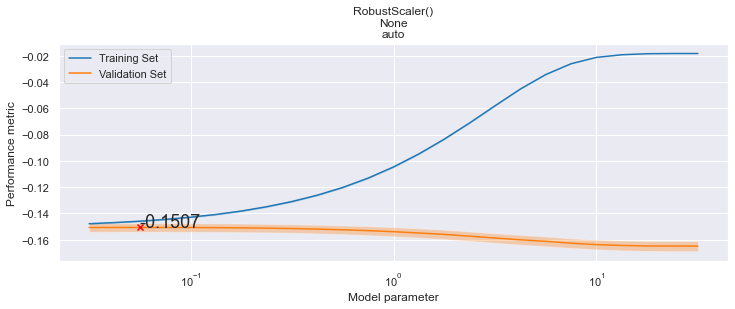

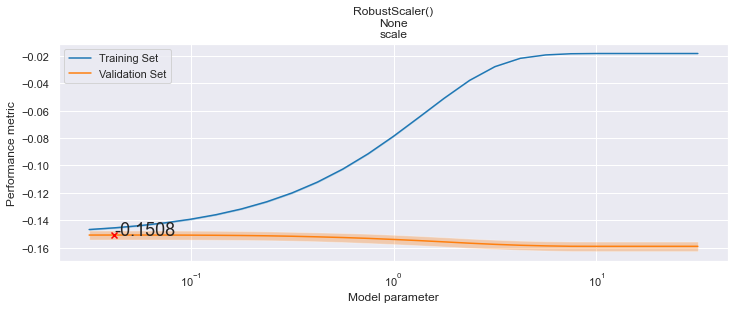

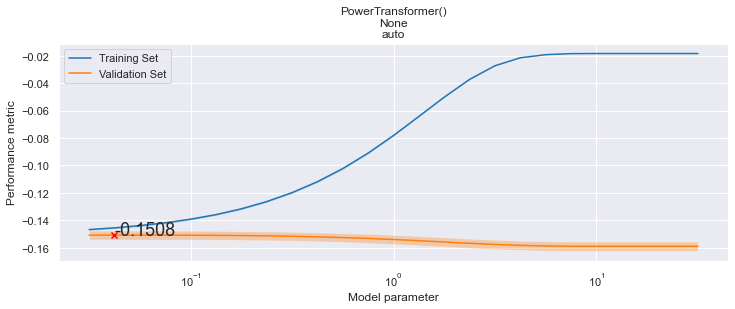

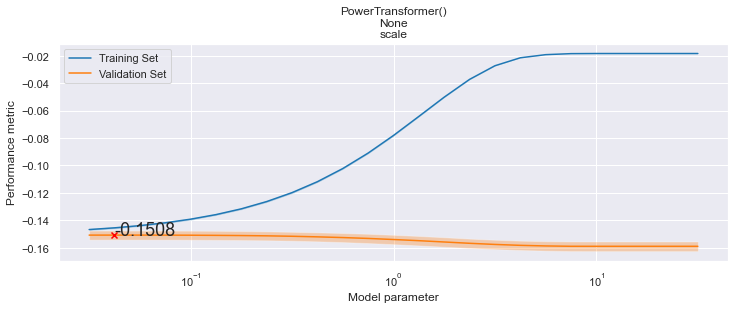

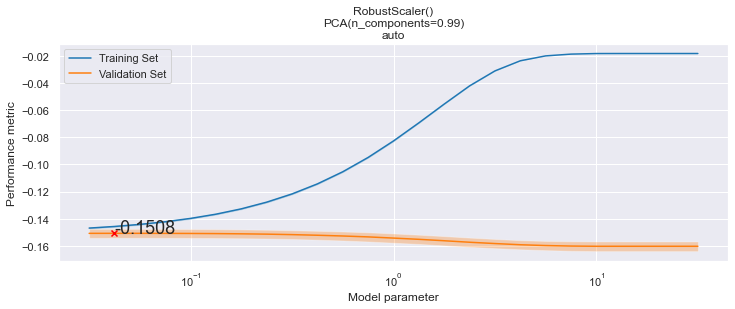

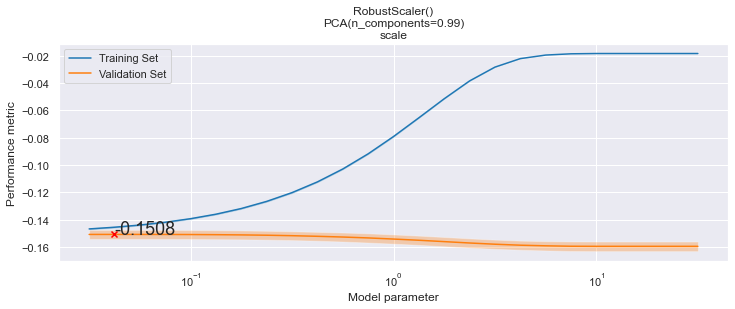

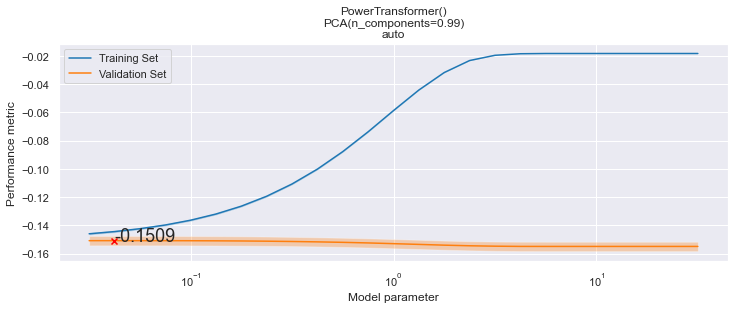

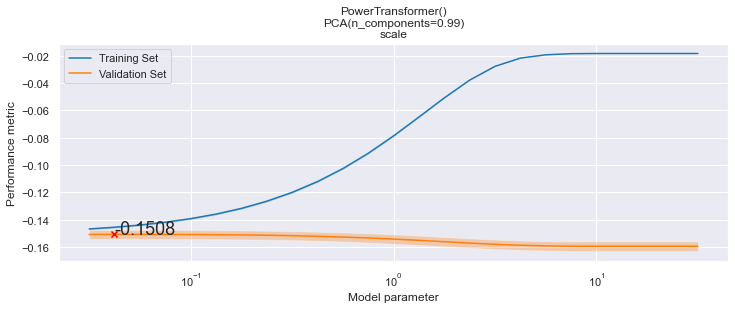

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
20          0.0562341                        2000                   auto   
12          0.0421697                        2000                   auto   
28          0.0749894                        2000                   auto   
4           0.0316228                        2000                   auto   
36                0.1                        2000                   auto   
14          0.0421697                        2000                   auto   
22          0.0562341                        2000                   auto   
8           0.0421697                        2000                  scale   
6           0.0316228                        2000                   auto   
16          0.0562341                        2000                  scale   
9           0.0421697                        2000                  scale   
13          0.0421697                        2000                   auto   
10          0.0421697                        2000                  scale   
11          0.0421697                        2000                  scale   
17          0.0562341                        2000                  scale   
21          0.0562341                        2000                   auto   
18          0.0562341                        2000                  scale   
5           0.0316228                        2000                   auto   
1           0.0316228                        2000                  scale   
0           0.0316228                        2000                  scale   

   param_estimator__kernel               param_pca        param_scaler  \
20                     rbf                    None      RobustScaler()   
12                     rbf                    None      RobustScaler()   
28                     rbf                    None      RobustScaler()   
4                      rbf                    None      RobustScaler()   
36                     rbf                    None      RobustScaler()   
14                     rbf  PCA(n_components=0.99)      RobustScaler()   
22                     rbf  PCA(n_components=0.99)      RobustScaler()   
8                      rbf                    None      RobustScaler()   
6                      rbf  PCA(n_components=0.99)      RobustScaler()   
16                     rbf                    None      RobustScaler()   
9                      rbf                    None  PowerTransformer()   
13                     rbf                    None  PowerTransformer()   
10                     rbf  PCA(n_components=0.99)      RobustScaler()   
11                     rbf  PCA(n_components=0.99)  PowerTransformer()   
17                     rbf                    None  PowerTransformer()   
21                     rbf                    None  PowerTransformer()   
18                     rbf  PCA(n_components=0.99)      RobustScaler()   
5                      rbf                    None  PowerTransformer()   
1                      rbf                    None  PowerTransformer()   
0                      rbf                    None      RobustScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
20        -0.150715        0.003281         -0.145933         0.000722  
12        -0.150723        0.003287         -0.147006         0.000741  
28        -0.150727        0.003278         -0.144582         0.000711  
4         -0.150745        0.003296         -0.147863         0.000764  
36        -0.150773        0.003285         -0.142900         0.000703  
14        -0.150778        0.003288         -0.145722         0.000743  
22        -0.150782        0.003280         -0.144194         0.000721  
8         -0.150786        0.003290         -0.145518         0.000748  
6         -0.150788        0.003299         -0.146911         0.000765  
16        -0.150789        0.003283         -0.143913         0.000725  
9         -0.150789        0.003296         -0.1

Starting with dataset merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 56.7min
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 103.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 133.3min finished


Best: -0.182022 using {'estimator__C': 0.23713737056616552, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


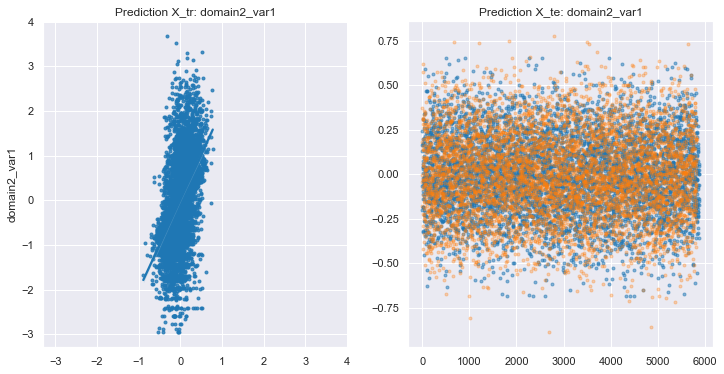

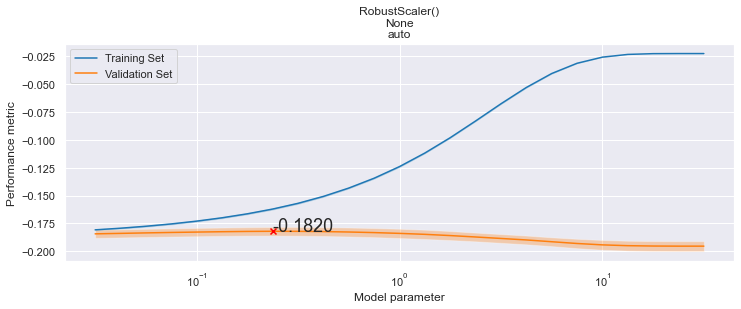

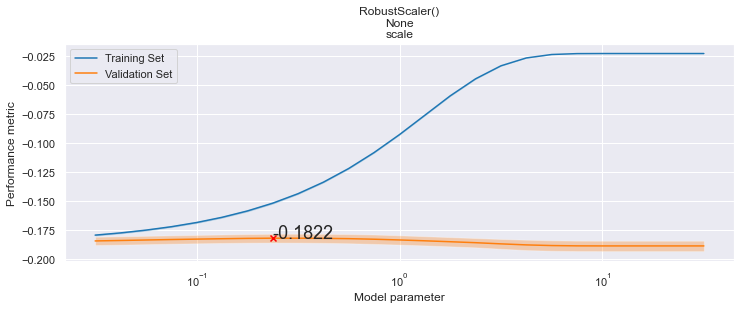

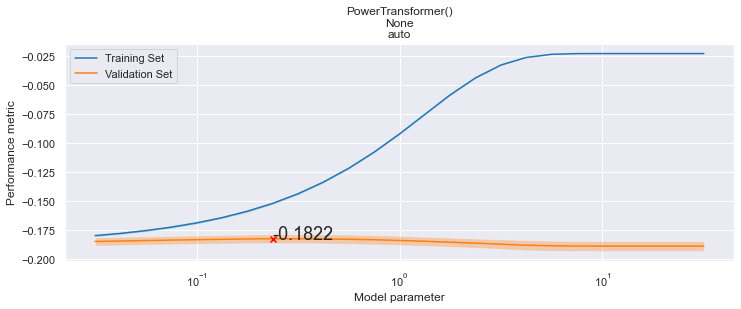

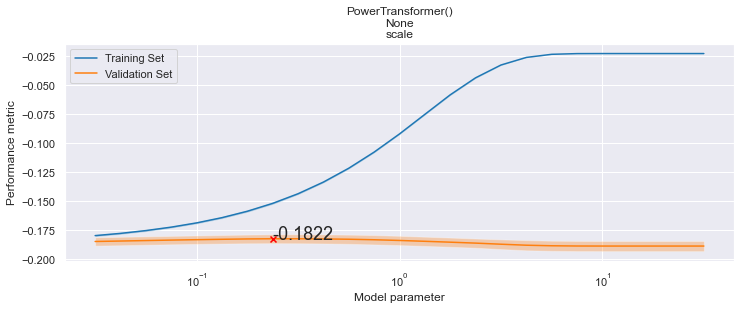

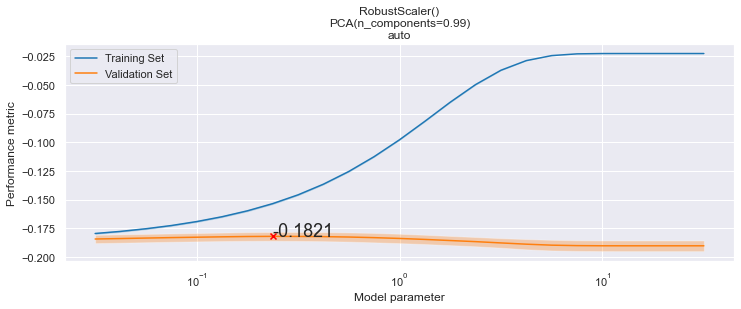

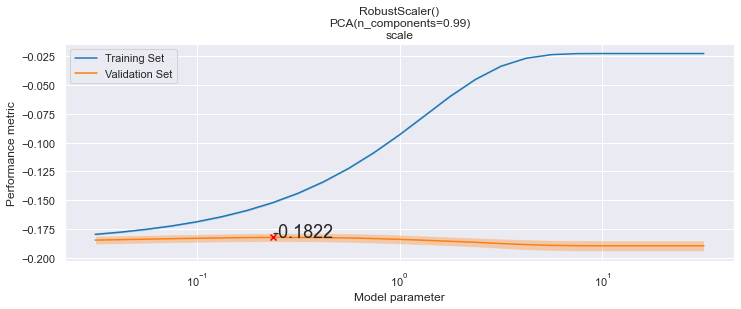

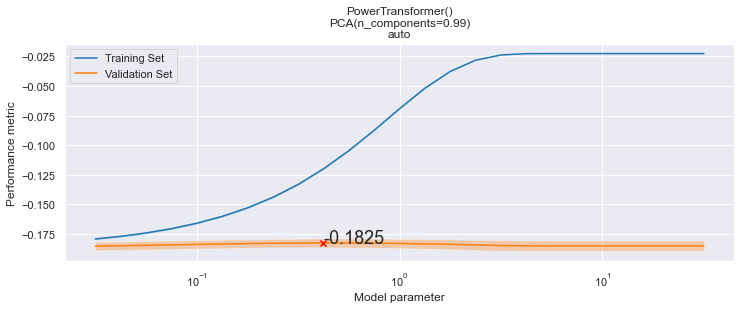

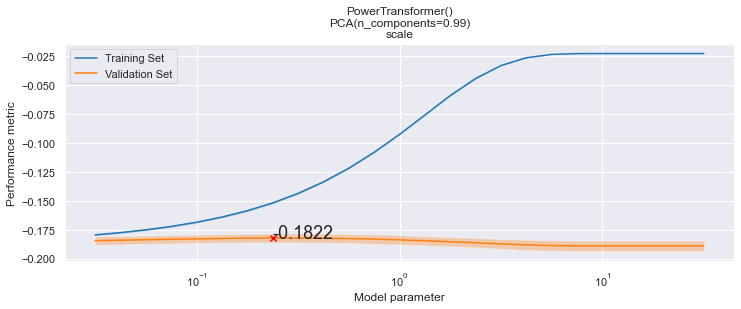

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
60           0.237137                        2000                   auto   
68           0.316228                        2000                   auto   
62           0.237137                        2000                   auto   
52           0.177828                        2000                   auto   
56           0.237137                        2000                  scale   
58           0.237137                        2000                  scale   
64           0.316228                        2000                  scale   
57           0.237137                        2000                  scale   
61           0.237137                        2000                   auto   
59           0.237137                        2000                  scale   
70           0.316228                        2000                   auto   
66           0.316228                        2000                  scale   
69           0.316228                        2000                   auto   
65           0.316228                        2000                  scale   
67           0.316228                        2000                  scale   
54           0.177828                        2000                   auto   
76           0.421697                        2000                   auto   
72           0.421697                        2000                  scale   
50           0.177828                        2000                  scale   
48           0.177828                        2000                  scale   

   param_estimator__kernel               param_pca        param_scaler  \
60                     rbf                    None      RobustScaler()   
68                     rbf                    None      RobustScaler()   
62                     rbf  PCA(n_components=0.99)      RobustScaler()   
52                     rbf                    None      RobustScaler()   
56                     rbf                    None      RobustScaler()   
58                     rbf  PCA(n_components=0.99)      RobustScaler()   
64                     rbf                    None      RobustScaler()   
57                     rbf                    None  PowerTransformer()   
61                     rbf                    None  PowerTransformer()   
59                     rbf  PCA(n_components=0.99)  PowerTransformer()   
70                     rbf  PCA(n_components=0.99)      RobustScaler()   
66                     rbf  PCA(n_components=0.99)      RobustScaler()   
69                     rbf                    None  PowerTransformer()   
65                     rbf                    None  PowerTransformer()   
67                     rbf  PCA(n_components=0.99)  PowerTransformer()   
54                     rbf  PCA(n_components=0.99)      RobustScaler()   
76                     rbf                    None      RobustScaler()   
72                     rbf                    None      RobustScaler()   
50                     rbf  PCA(n_components=0.99)      RobustScaler()   
48                     rbf                    None      RobustScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
60        -0.182022        0.003874         -0.162086         0.000975  
68        -0.182078        0.003922         -0.156959         0.000981  
62        -0.182135        0.003832         -0.153578         0.000923  
52        -0.182153        0.003780         -0.166359         0.000943  
56        -0.182164        0.003789         -0.151918         0.000926  
58        -0.182178        0.003805         -0.152014         0.000925  
64        -0.182180        0.003837         -0.143718         0.000879  
57        -0.182195        0.003812         -0.151699         0.000917  
61        -0.182195        0.003812         -0.151702         0.000918  
59        -0.182201        0.003828         -0.151867         0.000914  
70        -0.182202        0.003881         -0.1

Starting with dataset merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 102.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 132.7min finished


Best: -0.176227 using {'estimator__C': 0.1778279410038923, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


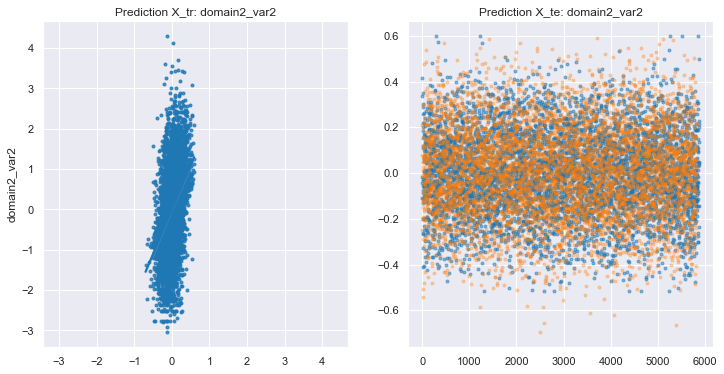

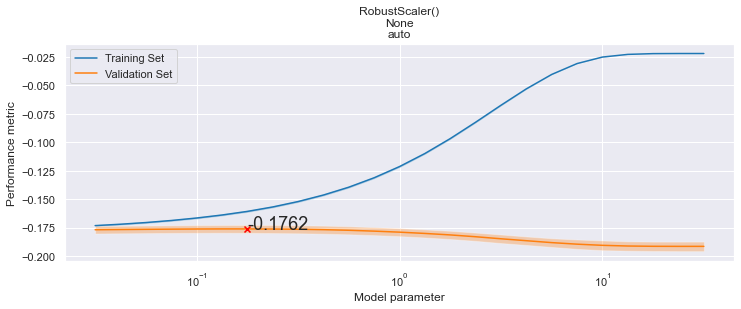

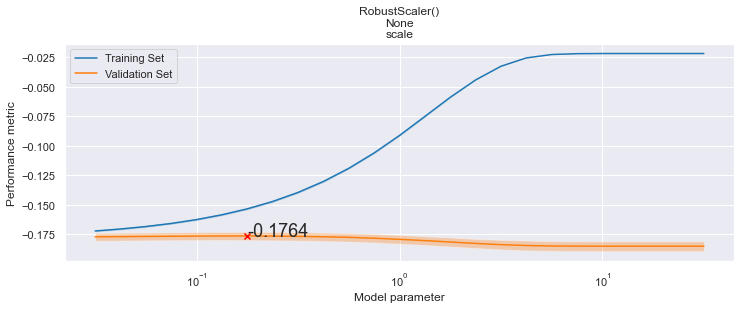

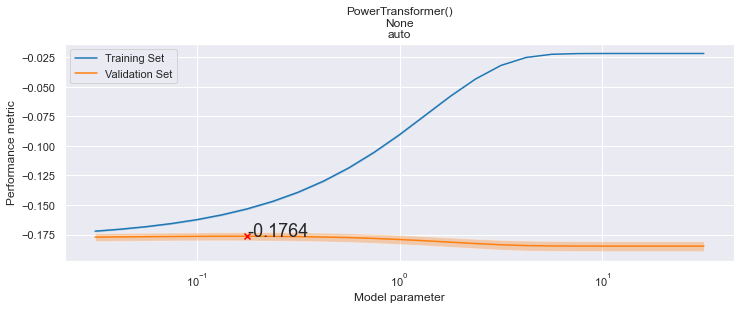

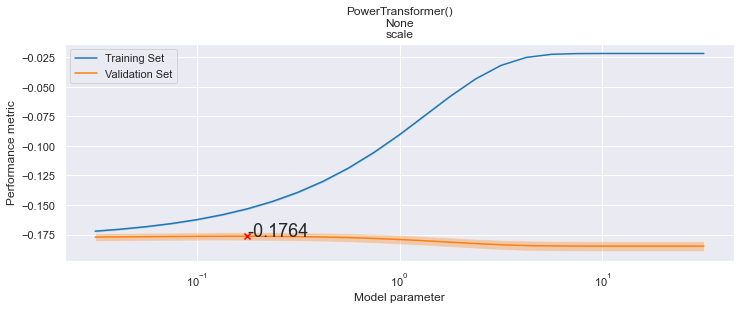

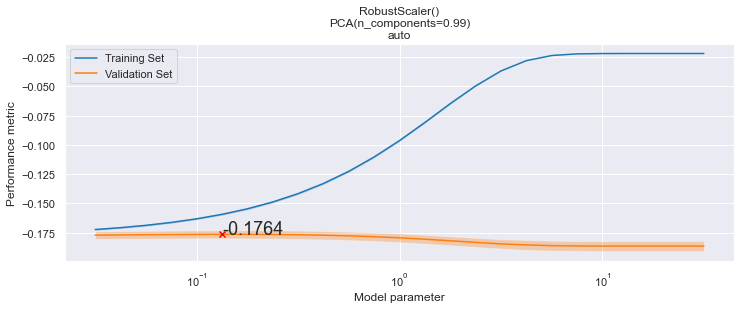

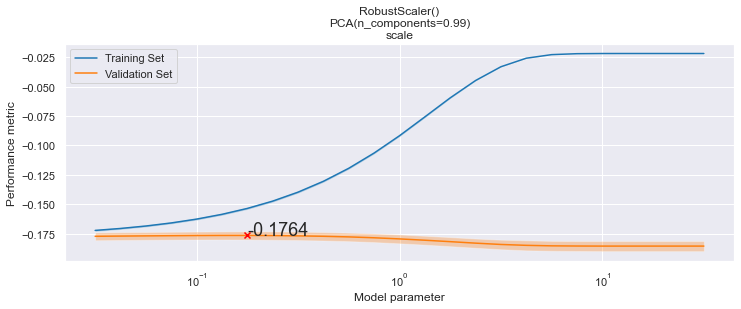

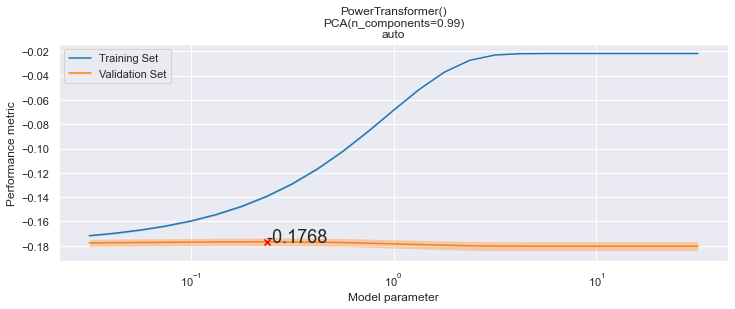

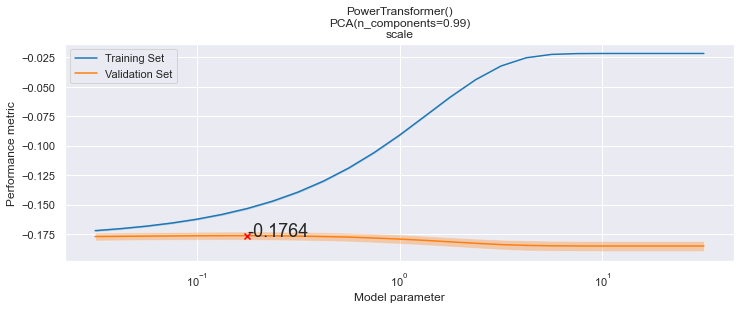

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
52           0.177828                        2000                   auto   
44           0.133352                        2000                   auto   
36                0.1                        2000                   auto   
60           0.237137                        2000                   auto   
46           0.133352                        2000                   auto   
54           0.177828                        2000                   auto   
48           0.177828                        2000                  scale   
53           0.177828                        2000                   auto   
49           0.177828                        2000                  scale   
51           0.177828                        2000                  scale   
28          0.0749894                        2000                   auto   
43           0.133352                        2000                  scale   
50           0.177828                        2000                  scale   
40           0.133352                        2000                  scale   
42           0.133352                        2000                  scale   
45           0.133352                        2000                   auto   
41           0.133352                        2000                  scale   
38                0.1                        2000                   auto   
34                0.1                        2000                  scale   
62           0.237137                        2000                   auto   

   param_estimator__kernel               param_pca        param_scaler  \
52                     rbf                    None      RobustScaler()   
44                     rbf                    None      RobustScaler()   
36                     rbf                    None      RobustScaler()   
60                     rbf                    None      RobustScaler()   
46                     rbf  PCA(n_components=0.99)      RobustScaler()   
54                     rbf  PCA(n_components=0.99)      RobustScaler()   
48                     rbf                    None      RobustScaler()   
53                     rbf                    None  PowerTransformer()   
49                     rbf                    None  PowerTransformer()   
51                     rbf  PCA(n_components=0.99)  PowerTransformer()   
28                     rbf                    None      RobustScaler()   
43                     rbf  PCA(n_components=0.99)  PowerTransformer()   
50                     rbf  PCA(n_components=0.99)      RobustScaler()   
40                     rbf                    None      RobustScaler()   
42                     rbf  PCA(n_components=0.99)      RobustScaler()   
45                     rbf                    None  PowerTransformer()   
41                     rbf                    None  PowerTransformer()   
38                     rbf  PCA(n_components=0.99)      RobustScaler()   
34                     rbf  PCA(n_components=0.99)      RobustScaler()   
62                     rbf  PCA(n_components=0.99)      RobustScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
52        -0.176227        0.003451         -0.160829         0.000918  
44        -0.176241        0.003380         -0.164009         0.000904  
36        -0.176313        0.003355         -0.166650         0.000882  
60        -0.176345        0.003521         -0.156933         0.000933  
46        -0.176395        0.003420         -0.159346         0.000910  
54        -0.176401        0.003488         -0.154633         0.000936  
48        -0.176439        0.003481         -0.153444         0.000921  
53        -0.176443        0.003516         -0.153266         0.000942  
49        -0.176443        0.003516         -0.153264         0.000940  
51        -0.176444        0.003519         -0.153368         0.000944  
28        -0.176445        0.003321         -0.1

score  estimator__C  estimator__cache_size estimator__gamma  \
0  0.148237      1.778279                   2000             auto   
1  0.152407      0.562341                   2000            scale   
2  0.150715      0.056234                   2000             auto   
3  0.182022      0.237137                   2000             auto   
4  0.176227      0.177828                   2000             auto   

  estimator__kernel   pca              scaler  
0               rbf  None      RobustScaler()  
1               rbf  None  PowerTransformer()  
2               rbf  None      RobustScaler()  
3               rbf  None      RobustScaler()  
4               rbf  None      RobustScaler()

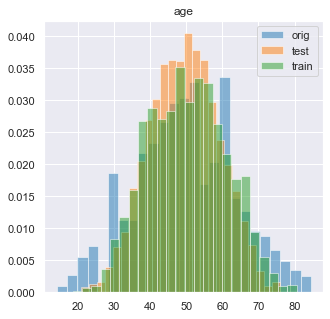

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


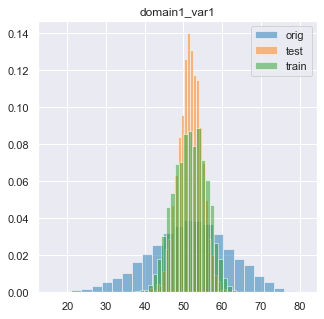

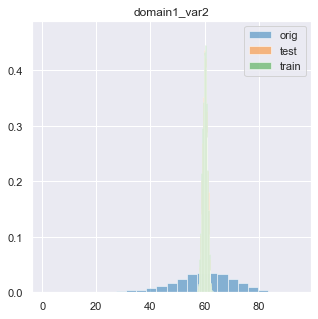

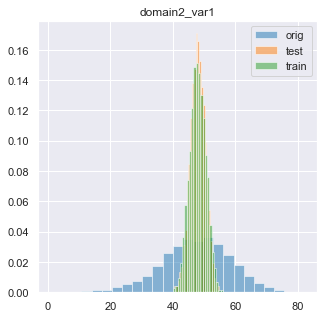

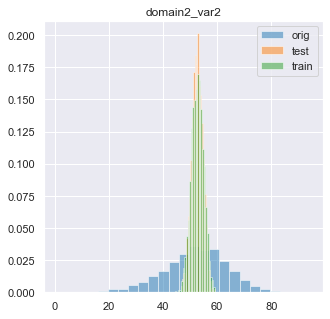

Score: 0.1602 | -0.1482 -0.1524 -0.1507 -0.1820 -0.1762


In [21]:
datasets_to_check = ['merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = SVR()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)

In [19]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    Cs = np.logspace(-1.5, 1.5, 25)
    param_grid = [
    { 
        'scaler': [RobustScaler()
                  ],
        'pca': [None],
        'estimator__C': Cs,
        'estimator__gamma': ['auto'],
        'estimator__kernel': ['rbf'],
        'estimator__cache_size': [2000],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

Starting with dataset short_merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5825, 1655)
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 84.0min finished


Best: -0.147390 using {'estimator__C': 1.7782794100389228, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


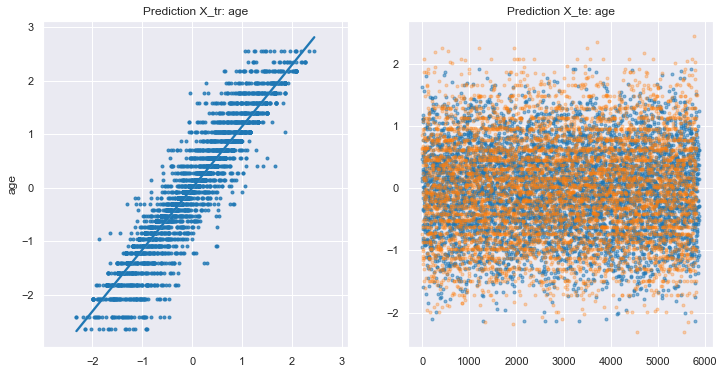

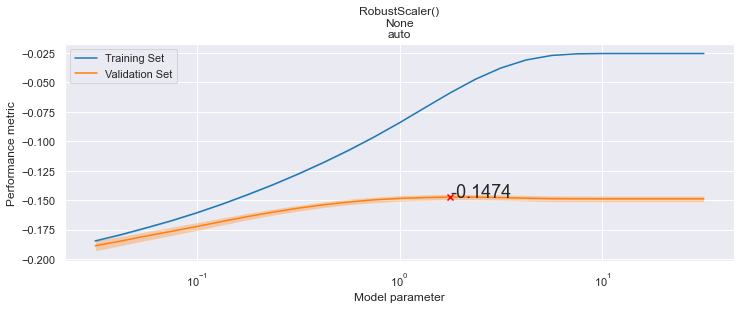

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
14            1.77828                        2000                   auto   
15            2.37137                        2000                   auto   
16            3.16228                        2000                   auto   
13            1.33352                        2000                   auto   
17            4.21697                        2000                   auto   
12                  1                        2000                   auto   
18            5.62341                        2000                   auto   
19            7.49894                        2000                   auto   
23            23.7137                        2000                   auto   
22            17.7828                        2000                   auto   
21            13.3352                        2000                   auto   
24            31.6228                        2000                   auto   
20                 10                        2000                   auto   
11           0.749894                        2000                   auto   
10           0.562341                        2000                   auto   
9            0.421697                        2000                   auto   
8            0.316228                        2000                   auto   
7            0.237137                        2000                   auto   
6            0.177828                        2000                   auto   
5            0.133352                        2000                   auto   

   param_estimator__kernel param_pca    param_scaler  mean_test_score  \
14                     rbf      None  RobustScaler()        -0.147390   
15                     rbf      None  RobustScaler()        -0.147447   
16                     rbf      None  RobustScaler()        -0.147794   
13                     rbf      None  RobustScaler()        -0.147797   
17                     rbf      None  RobustScaler()        -0.148353   
12                     rbf      None  RobustScaler()        -0.148528   
18                     rbf      None  RobustScaler()        -0.148748   
19                     rbf      None  RobustScaler()        -0.148875   
23                     rbf      None  RobustScaler()        -0.148887   
22                     rbf      None  RobustScaler()        -0.148887   
21                     rbf      None  RobustScaler()        -0.148887   
24                     rbf      None  RobustScaler()        -0.148887   
20                     rbf      None  RobustScaler()        -0.148887   
11                     rbf      None  RobustScaler()        -0.149772   
10                     rbf      None  RobustScaler()        -0.151580   
9                      rbf      None  RobustScaler()        -0.153954   
8                      rbf      None  RobustScaler()        -0.156845   
7                      rbf      None  RobustScaler()        -0.160238   
6                      rbf      None  RobustScaler()        -0.163993   
5                      rbf      None  RobustScaler()        -0.168130   

    std_test_score  mean_train_score  std_train_score  
14        0.002577         -0.058896         0.000307  
15        0.002544         -0.047266         0.000328  
16        0.002531         -0.037778         0.000302  
13        0.002627         -0.071512         0.000388  
17        0.002664         -0.030941         0.000290  
12        0.002645         -0.084278         0.000476  
18        0.002738         -0.027157         0.000179  
19        0.002740         -0.025776         0.000087  
23        0.002731         -0.025513         0.000072  
22        0.002731         -0.025513         0.000072  
21        0.002731         -0.025513         0.000072  
24        0.002731         -0.025513         0.000072  
20        0.002730         -0.025515         0.000072  
11        0.002633         -0.096357         0.000569  
10        0.002601         -0.10

Starting with dataset short_merge - target: domain1_var1
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 81.9min finished


Best: -0.150425 using {'estimator__C': 0.5623413251903491, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


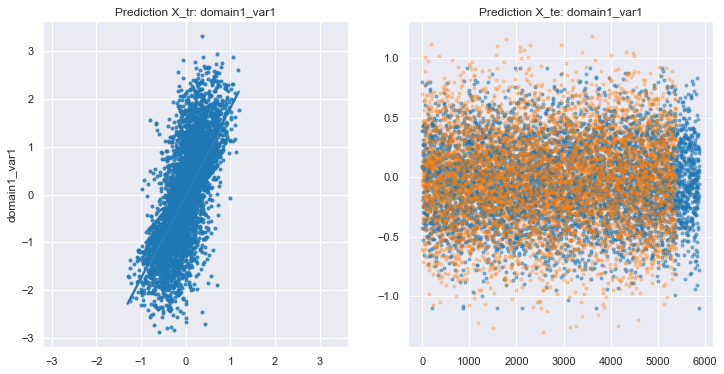

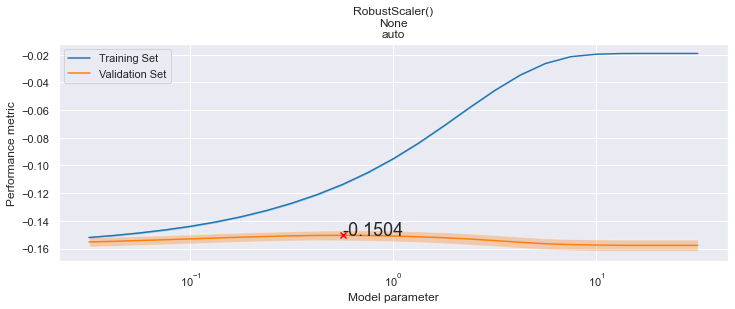

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
10           0.562341                        2000                   auto   
9            0.421697                        2000                   auto   
11           0.749894                        2000                   auto   
8            0.316228                        2000                   auto   
12                  1                        2000                   auto   
7            0.237137                        2000                   auto   
13            1.33352                        2000                   auto   
6            0.177828                        2000                   auto   
14            1.77828                        2000                   auto   
5            0.133352                        2000                   auto   
4                 0.1                        2000                   auto   
15            2.37137                        2000                   auto   
3           0.0749894                        2000                   auto   
2           0.0562341                        2000                   auto   
16            3.16228                        2000                   auto   
1           0.0421697                        2000                   auto   
0           0.0316228                        2000                   auto   
17            4.21697                        2000                   auto   
18            5.62341                        2000                   auto   
19            7.49894                        2000                   auto   

   param_estimator__kernel param_pca    param_scaler  mean_test_score  \
10                     rbf      None  RobustScaler()        -0.150425   
9                      rbf      None  RobustScaler()        -0.150488   
11                     rbf      None  RobustScaler()        -0.150549   
8                      rbf      None  RobustScaler()        -0.150805   
12                     rbf      None  RobustScaler()        -0.150921   
7                      rbf      None  RobustScaler()        -0.151253   
13                     rbf      None  RobustScaler()        -0.151494   
6                      rbf      None  RobustScaler()        -0.151766   
14                     rbf      None  RobustScaler()        -0.152165   
5                      rbf      None  RobustScaler()        -0.152361   
4                      rbf      None  RobustScaler()        -0.152984   
15                     rbf      None  RobustScaler()        -0.153083   
3                      rbf      None  RobustScaler()        -0.153584   
2                      rbf      None  RobustScaler()        -0.154169   
16                     rbf      None  RobustScaler()        -0.154201   
1                      rbf      None  RobustScaler()        -0.154740   
0                      rbf      None  RobustScaler()        -0.155246   
17                     rbf      None  RobustScaler()        -0.155434   
18                     rbf      None  RobustScaler()        -0.156522   
19                     rbf      None  RobustScaler()        -0.157124   

    std_test_score  mean_train_score  std_train_score  
10        0.003646         -0.113667         0.000812  
9         0.003468         -0.120972         0.000824  
11        0.003777         -0.105062         0.000804  
8         0.003327         -0.127196         0.000806  
12        0.003821         -0.095105         0.000744  
7         0.003299         -0.132507         0.000790  
13        0.003878         -0.083785         0.000683  
6         0.003299         -0.136986         0.000764  
14        0.003963         -0.071322         0.000657  
5         0.003288         -0.140766         0.000786  
4         0.003281         -0.143910         0.000809  
15        0.004003         -0.058320         0.000596  
3         0.003267         -0.146501         0.000832  
2         0.003272         -0.148673         0.000826  
16        0.004018         -0.04

Starting with dataset short_merge - target: domain1_var2
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 81.9min finished


Best: -0.148867 using {'estimator__C': 0.31622776601683794, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


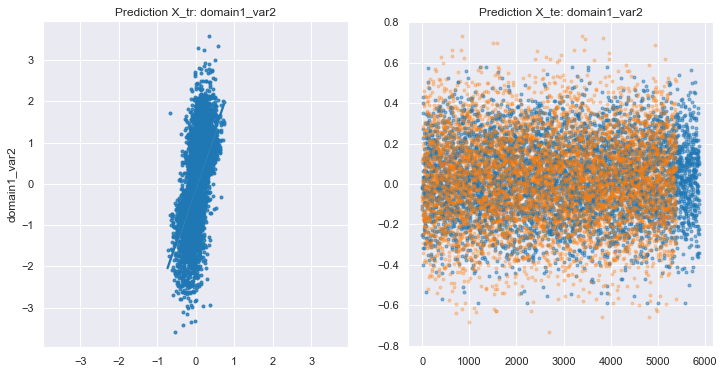

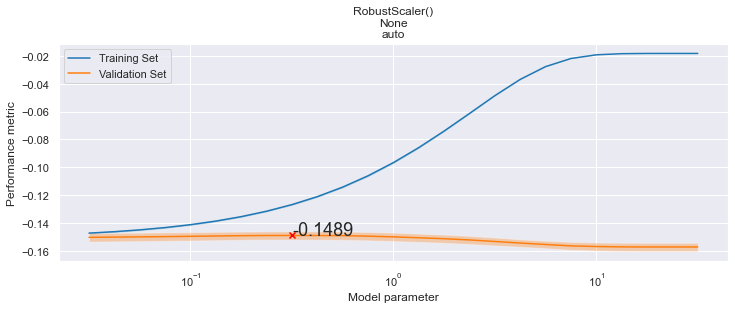

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
8            0.316228                        2000                   auto   
7            0.237137                        2000                   auto   
9            0.421697                        2000                   auto   
10           0.562341                        2000                   auto   
6            0.177828                        2000                   auto   
5            0.133352                        2000                   auto   
11           0.749894                        2000                   auto   
4                 0.1                        2000                   auto   
3           0.0749894                        2000                   auto   
12                  1                        2000                   auto   
2           0.0562341                        2000                   auto   
1           0.0421697                        2000                   auto   
0           0.0316228                        2000                   auto   
13            1.33352                        2000                   auto   
14            1.77828                        2000                   auto   
15            2.37137                        2000                   auto   
16            3.16228                        2000                   auto   
17            4.21697                        2000                   auto   
18            5.62341                        2000                   auto   
19            7.49894                        2000                   auto   

   param_estimator__kernel param_pca    param_scaler  mean_test_score  \
8                      rbf      None  RobustScaler()        -0.148867   
7                      rbf      None  RobustScaler()        -0.148891   
9                      rbf      None  RobustScaler()        -0.148895   
10                     rbf      None  RobustScaler()        -0.149013   
6                      rbf      None  RobustScaler()        -0.149027   
5                      rbf      None  RobustScaler()        -0.149252   
11                     rbf      None  RobustScaler()        -0.149372   
4                      rbf      None  RobustScaler()        -0.149483   
3                      rbf      None  RobustScaler()        -0.149701   
12                     rbf      None  RobustScaler()        -0.149869   
2                      rbf      None  RobustScaler()        -0.149883   
1                      rbf      None  RobustScaler()        -0.150054   
0                      rbf      None  RobustScaler()        -0.150196   
13                     rbf      None  RobustScaler()        -0.150512   
14                     rbf      None  RobustScaler()        -0.151195   
15                     rbf      None  RobustScaler()        -0.152081   
16                     rbf      None  RobustScaler()        -0.153175   
17                     rbf      None  RobustScaler()        -0.154296   
18                     rbf      None  RobustScaler()        -0.155337   
19                     rbf      None  RobustScaler()        -0.156319   

    std_test_score  mean_train_score  std_train_score  
8         0.002925         -0.126732         0.000623  
7         0.002910         -0.131464         0.000603  
9         0.002961         -0.121018         0.000660  
10        0.002962         -0.114176         0.000690  
6         0.002937         -0.135366         0.000624  
5         0.002975         -0.138546         0.000622  
11        0.002984         -0.106052         0.000737  
4         0.002987         -0.141126         0.000626  
3         0.003008         -0.143196         0.000638  
12        0.002990         -0.096596         0.000719  
2         0.003022         -0.144839         0.000661  
1         0.003040         -0.146144         0.000682  
0         0.003050         -0.147185         0.000707  
13        0.002963         -0.085835         0.000670  
14        0.002918         -0.07

Starting with dataset short_merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 94.1min finished


Best: -0.179866 using {'estimator__C': 0.4216965034285822, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


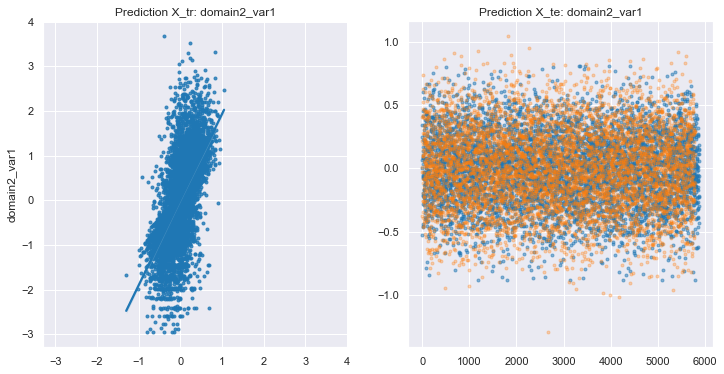

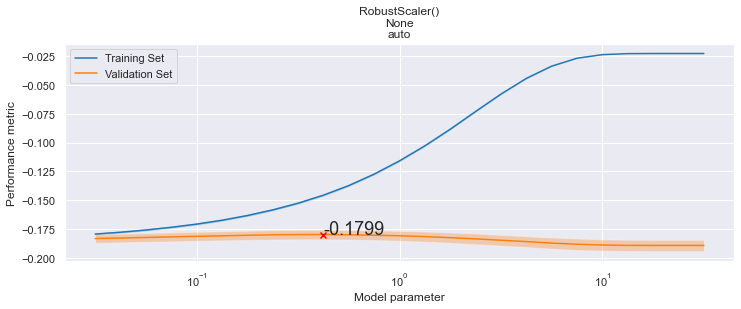

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
9            0.421697                        2000                   auto   
8            0.316228                        2000                   auto   
7            0.237137                        2000                   auto   
10           0.562341                        2000                   auto   
11           0.749894                        2000                   auto   
6            0.177828                        2000                   auto   
12                  1                        2000                   auto   
5            0.133352                        2000                   auto   
4                 0.1                        2000                   auto   
13            1.33352                        2000                   auto   
3           0.0749894                        2000                   auto   
2           0.0562341                        2000                   auto   
14            1.77828                        2000                   auto   
1           0.0421697                        2000                   auto   
0           0.0316228                        2000                   auto   
15            2.37137                        2000                   auto   
16            3.16228                        2000                   auto   
17            4.21697                        2000                   auto   
18            5.62341                        2000                   auto   
19            7.49894                        2000                   auto   

   param_estimator__kernel param_pca    param_scaler  mean_test_score  \
9                      rbf      None  RobustScaler()        -0.179866   
8                      rbf      None  RobustScaler()        -0.179873   
7                      rbf      None  RobustScaler()        -0.180078   
10                     rbf      None  RobustScaler()        -0.180101   
11                     rbf      None  RobustScaler()        -0.180470   
6                      rbf      None  RobustScaler()        -0.180509   
12                     rbf      None  RobustScaler()        -0.180935   
5                      rbf      None  RobustScaler()        -0.180967   
4                      rbf      None  RobustScaler()        -0.181410   
13                     rbf      None  RobustScaler()        -0.181656   
3                      rbf      None  RobustScaler()        -0.181880   
2                      rbf      None  RobustScaler()        -0.182376   
14                     rbf      None  RobustScaler()        -0.182590   
1                      rbf      None  RobustScaler()        -0.182867   
0                      rbf      None  RobustScaler()        -0.183302   
15                     rbf      None  RobustScaler()        -0.183610   
16                     rbf      None  RobustScaler()        -0.184808   
17                     rbf      None  RobustScaler()        -0.185981   
18                     rbf      None  RobustScaler()        -0.187285   
19                     rbf      None  RobustScaler()        -0.188280   

    std_test_score  mean_train_score  std_train_score  
9         0.004121         -0.145669         0.000961  
8         0.004115         -0.152630         0.000968  
7         0.004057         -0.158446         0.000975  
10        0.004075         -0.137311         0.000935  
11        0.004127         -0.127391         0.000921  
6         0.003989         -0.163334         0.000987  
12        0.004268         -0.115873         0.000844  
5         0.003925         -0.167436         0.000962  
4         0.003874         -0.170787         0.000963  
13        0.004369         -0.102832         0.000798  
3         0.003861         -0.173552         0.000945  
2         0.003813         -0.175906         0.000952  
14        0.004493         -0.088388         0.000759  
1         0.003769         -0.177848         0.000949  
0         0.003731         -0.17

Starting with dataset short_merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 85.0min finished


Best: -0.174193 using {'estimator__C': 0.31622776601683794, 'estimator__cache_size': 2000, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'pca': None, 'scaler': RobustScaler()}


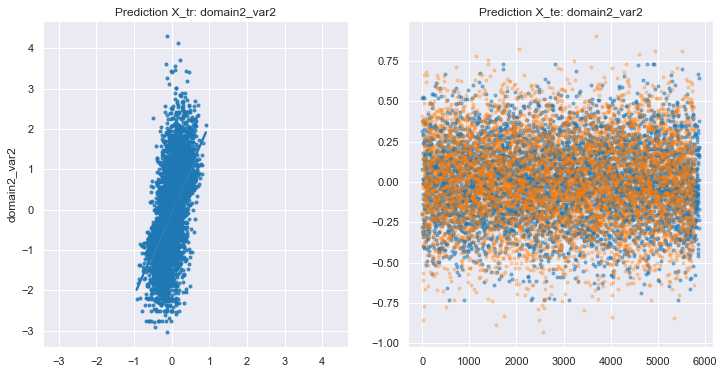

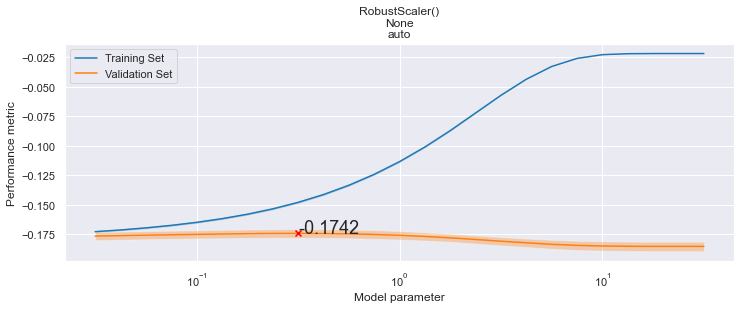

param_estimator__C param_estimator__cache_size param_estimator__gamma  \
8            0.316228                        2000                   auto   
7            0.237137                        2000                   auto   
9            0.421697                        2000                   auto   
6            0.177828                        2000                   auto   
10           0.562341                        2000                   auto   
5            0.133352                        2000                   auto   
4                 0.1                        2000                   auto   
11           0.749894                        2000                   auto   
3           0.0749894                        2000                   auto   
2           0.0562341                        2000                   auto   
12                  1                        2000                   auto   
1           0.0421697                        2000                   auto   
0           0.0316228                        2000                   auto   
13            1.33352                        2000                   auto   
14            1.77828                        2000                   auto   
15            2.37137                        2000                   auto   
16            3.16228                        2000                   auto   
17            4.21697                        2000                   auto   
18            5.62341                        2000                   auto   
19            7.49894                        2000                   auto   

   param_estimator__kernel param_pca    param_scaler  mean_test_score  \
8                      rbf      None  RobustScaler()        -0.174193   
7                      rbf      None  RobustScaler()        -0.174216   
9                      rbf      None  RobustScaler()        -0.174264   
6                      rbf      None  RobustScaler()        -0.174406   
10                     rbf      None  RobustScaler()        -0.174567   
5                      rbf      None  RobustScaler()        -0.174688   
4                      rbf      None  RobustScaler()        -0.175002   
11                     rbf      None  RobustScaler()        -0.175048   
3                      rbf      None  RobustScaler()        -0.175320   
2                      rbf      None  RobustScaler()        -0.175661   
12                     rbf      None  RobustScaler()        -0.175732   
1                      rbf      None  RobustScaler()        -0.176035   
0                      rbf      None  RobustScaler()        -0.176414   
13                     rbf      None  RobustScaler()        -0.176723   
14                     rbf      None  RobustScaler()        -0.177921   
15                     rbf      None  RobustScaler()        -0.179306   
16                     rbf      None  RobustScaler()        -0.180762   
17                     rbf      None  RobustScaler()        -0.182096   
18                     rbf      None  RobustScaler()        -0.183393   
19                     rbf      None  RobustScaler()        -0.184292   

    std_test_score  mean_train_score  std_train_score  
8         0.003633         -0.147905         0.000944  
7         0.003582         -0.153383         0.000929  
9         0.003636         -0.141311         0.000936  
6         0.003544         -0.157948         0.000914  
10        0.003673         -0.133442         0.000947  
5         0.003536         -0.161685         0.000914  
4         0.003483         -0.164801         0.000888  
11        0.003674         -0.124195         0.000903  
3         0.003434         -0.167358         0.000895  
2         0.003407         -0.169477         0.000887  
12        0.003577         -0.113430         0.000847  
1         0.003420         -0.171240         0.000896  
0         0.003420         -0.172685         0.000906  
13        0.003456         -0.101048         0.000797  
14        0.003378         -0.08

score  estimator__C  estimator__cache_size estimator__gamma  \
0  0.147390      1.778279                   2000             auto   
1  0.150425      0.562341                   2000             auto   
2  0.148867      0.316228                   2000             auto   
3  0.179866      0.421697                   2000             auto   
4  0.174193      0.316228                   2000             auto   

  estimator__kernel   pca          scaler  
0               rbf  None  RobustScaler()  
1               rbf  None  RobustScaler()  
2               rbf  None  RobustScaler()  
3               rbf  None  RobustScaler()  
4               rbf  None  RobustScaler()

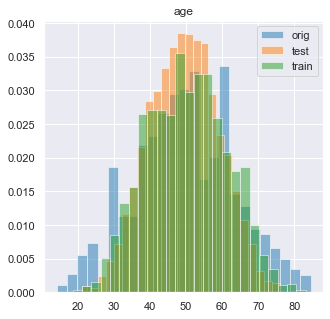

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


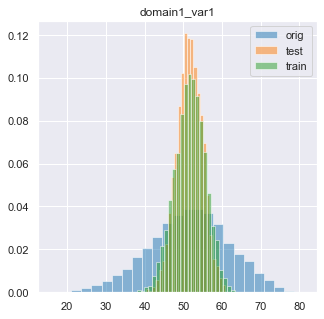

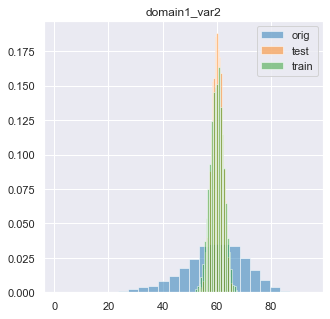

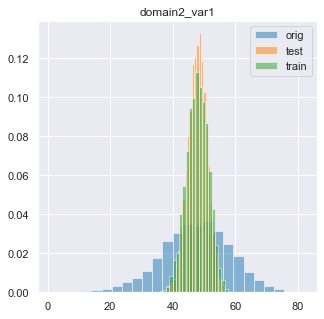

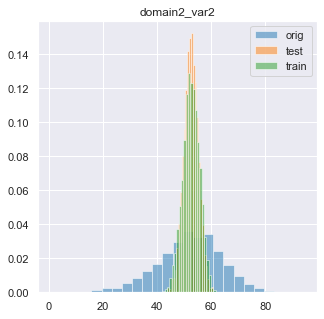

Score: 0.1586 | -0.1474 -0.1504 -0.1489 -0.1799 -0.1742


In [20]:
datasets_to_check = ['short_merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = SVR()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)